MRDI comparison at the individual transect level.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import sad_mrdi as sm
%matplotlib inline

In [2]:
# Import data
ad = pd.read_csv('./RawData/Azores_Adults.csv',header=[0,1])

In [3]:
# Get land use types
lu = list(ad.columns.levels[0])
lu.remove('Data')
# Reorder to disturbance gradient
lu = [lu[2],lu[0],lu[3],lu[1]]
# Get how many sites for each land use
lu_sites = pd.Series(index=lu,dtype=int)
for l in lu:
    lu_sites[l] = len(ad[l].columns)

# Get list of sites, ignoring first 4 indices which are data information
ls = ad.columns[9:]

# Make arrays using ls instead of lu
# For s,n,beta. Later e0 and lambdas.
sne = pd.DataFrame(index=ls,columns = {'s0','n0','e0','beta','l1','l2'})
# For abundances
abd = pd.DataFrame(columns=ls)
for l in ls:
    abd[l] = ad[l]
    # Get n0 and s0
    stemp = np.count_nonzero(abd[l])
    ntemp = abd[l].sum()
    # Get beta
    btemp = sm.get_beta(stemp,ntemp)
    # Add to dataframe
    sne.loc[l] = {'n0': ntemp, 's0': stemp, 'beta': btemp}
    
# Rename indexes for abundaces to species code
abd.rename(index=ad['Data','MF'],inplace=True)
abd.index.name = 'MF'

# Fix datatype for sne_lu
sne = sne.astype({'s0': 'int64','n0':'int64','beta':'float64'})
display(sne)

l1  s0      beta   l2   n0   e0
Exotic forest        TER-AGUA-T-66  NaN  13  0.089854  NaN   56  NaN
                     TER-MNEG-T-62  NaN  21  0.030485  NaN  193  NaN
                     TER-MNEG-T-63  NaN  15  0.033242  NaN  128  NaN
                     TER-TCHA-T-64  NaN  20  0.016423  NaN  291  NaN
                     TER-ACAR-T111  NaN  14  0.084279  NaN   63  NaN
...                                 ...  ..       ...  ...  ...  ...
Semi-natural pasture TER-NFPG-T-67  NaN  26  0.020813  NaN  318  NaN
                     TER-NFTB-T117  NaN  15  0.013750  NaN  244  NaN
                     TER-NFTB-T-28  NaN  20  0.025231  NaN  211  NaN
                     TER-PB-T165    NaN  27  0.007316  NaN  744  NaN
                     TER-SBAR-T-72  NaN  18  0.004575  NaN  700  NaN

[96 rows x 6 columns]

# Simulate datasets

In [4]:
# Set up regression relationships from BodyMassVariance.ipynb
# Note these are for the log relationship
# For beetles
bi = -1.243073857459273
bs = 1.9948767678521848
# For spiders
si = -1.1467463900692998
ss = 2.2207391333864335

In [5]:
# Set random seed
prng = np.random.RandomState(101)
# Make a dictionary with labeled land uses
biomass = {}
for l in ls:
    # Find args for this land use where the abundance is non-zero
    args_temp = np.where(abd[l])[0]
    # Get abundances just for this site
    abd_temp = abd[l].iloc[args_temp]
    # Now simulate that number of points for each species
    biomass[l] = np.array([])
    for mf in abd_temp.index:
        # pull abd_temp[mf] number of points from a normal distribution
        # where the mean is given by the mean in the main dataset
        # and the standard deviation is given by the regression relationships above
        mean = ad[ad['Data','MF']==mf]['Data','Body_Mass.mg.']
        # Use the beetle regression
        if (ad[ad['Data','MF']==mf]['Data','Order (new)'].values[0]=='Araneae'):
            var = 10**(si+ss*np.log10(mean))
        else:
            var = 10**(bi+bs*np.log10(mean))
        biomass[l] = np.append(biomass[l],
                               st.norm.rvs(loc=mean,scale=np.sqrt(var),size=abd_temp[mf],random_state=prng))
        # There is an issue here where depending on random seed we can get biomasses below zero, 
        # but let's ignore that.

In [6]:
# For now put less than zeros to minimum in that area, but may change this later.
# I added to this to remove duplicates so that the KS test can be trusted
for l in ls:
    inds = biomass[l]<0
    if np.any(inds):
        print("Problem point",biomass[l][biomass[l]<0])
        # To avoid duplicates, add a tiny noise to this.
        biomass[l][inds] = np.min(biomass[l][~inds])*(1+0.01*st.norm.rvs(random_state=prng))
        print("Should be empty",biomass[l][biomass[l]<0])
        print("Previous minimum",np.min(biomass[l][~inds]))
        print("Newly added",biomass[l][inds])
        print()

Problem point [-0.13374193]
Should be empty []
Previous minimum 0.09499822116490637
Newly added [0.09613203]

Problem point [-0.00992862]
Should be empty []
Previous minimum 0.018396147975869
Newly added [0.01839378]



In [7]:
# Now convert to metabolic rate
mr = biomass.copy()
for l in ls:
    # Now sort the array, convert to metabolic rate (m \propto e^(4/3)), and divide by smallest
    # Order doesn't matter here
    mr[l] = np.sort(mr[l]**(3/4))
    # Note that this way, the e0 between the land uses actually isn't comparable 
    #because the smallest unit is different
    mr[l] = mr[l]/mr[l][0]
    
for l in ls:
    sne.loc[l,'e0'] = mr[l].sum()
sne['l2'] = sne['s0']/(sne['e0']-sne['n0'])
sne['l1'] = sne['beta']-sne['l2']

In [8]:
# Check for duplicates
for l in ls:
    if len(np.unique(mr[l])) != len(mr[l]):
        print("Ruh roh!")

# KS TEST

## Goodness of fit and summary plots


In [10]:
# KS test
ks = pd.DataFrame(index=ls,columns=['D','p'],dtype='float64')

for l in ls:
    ks.loc[l] = st.kstest(mr[l], lambda x: sm.mrdi_cdf(x, (sne.loc[l,'l1'],sne.loc[l,'l2'])) )

sne['ksD'] = ks['D']
sne['ksp'] = ks['p']

In [11]:
# To get the standard error of the mean, we have to divide by sqrt(n)
mean = sne['ksD'].mean(level=0)
display(mean)
se = sne['ksD'].std(level=0)
for l in lu:
    se.loc[l] /= np.sqrt(lu_sites[l])
display(se)

Exotic forest           0.282735
Native forest           0.289499
Intensive pasture       0.380308
Semi-natural pasture    0.443228
Name: ksD, dtype: float64

Exotic forest           0.033803
Native forest           0.011946
Intensive pasture       0.024954
Semi-natural pasture    0.030331
Name: ksD, dtype: float64

In [12]:
ksD_data = pd.DataFrame([mean,se],index = ['Mean','Standard error'])
display(ksD_data)
ksD_data.to_csv("ProcessedData/mrdi_means_ksD.csv")

,Exotic forest,Native forest,Intensive pasture,Semi-natural pasture
Mean,0.282735,0.289499,0.380308,0.443228
Standard error,0.033803,0.011946,0.024954,0.030331


# LEAST SQUARES

## Goodness of fit and summary plots

In [9]:
# Use mean least squares
mlsq = pd.Series(index=ls,dtype='float64')
for l in ls:
    ranks = np.arange(sne.loc[l,'n0'])+1
#    print(ranks)
#    print(sne.loc[l,'l1'],sne.loc[l,'l2'])
#    print(sne.loc[l,'n0'])
    pred = sm.mrdi_rank(ranks,(sne.loc[l,'l1'],sne.loc[l,'l2']),sne.loc[l,'n0'])
    obs = mr[l][::-1]
    # If we have any less than 0, ignore that because n0 is too small.
    if np.any(pred <= 0):
        mlsq[l] = np.nan
    elif sne['n0'][l] == len(obs):
        mlsq[l] = np.sum((np.log(obs)-np.log(pred))**2)/len(obs)
    else:
        print("Ruh ro!")

# modify number of sites with number of nans
lu_sites_alt = lu_sites.copy()
lu_sites_alt -= mlsq.isna().sum(level=0)
        
sne['mlsq'] = mlsq

In [10]:
# Note that .std in pandas already has ddof=1, which is correct here since we estimate the mean
# To get the standard error of the mean, we have to divide by sqrt(n)
mean = sne['mlsq'].mean(level=0)
display(mean)
se = sne['mlsq'].std(level=0)
for l in lu:
    se.loc[l] /= np.sqrt(lu_sites_alt[l])
display(se)

Exotic forest           0.402112
Native forest           0.473666
Intensive pasture       0.671029
Semi-natural pasture    0.812182
Name: mlsq, dtype: float64

Exotic forest           0.076547
Native forest           0.048898
Intensive pasture       0.064003
Semi-natural pasture    0.101602
Name: mlsq, dtype: float64

In [11]:
# save the means and full datato file
mlsq_data = pd.DataFrame([mean,se,lu_sites_alt],index=['Mean','Standard error','N'])
display(mlsq_data)
mlsq_data.to_csv('ProcessedData/mrdi_mlsq.csv')
sne.to_csv('ProcessedData/mrdi_data.csv')

,Exotic forest,Native forest,Intensive pasture,Semi-natural pasture
Mean,0.402112,0.473666,0.671029,0.812182
Standard error,0.076547,0.048898,0.064003,0.101602
N,12.000000,44.000000,24.000000,16.000000


## Plots for each site

In [12]:
# This is the new better colour scheme and better number of columns
# Make color dictionary
cdic = {lu[0]:'tab:green',lu[1]:'tab:blue',lu[2]:'tab:orange',lu[3]:'tab:red'}
for l in lu:
    nsites = len(ad[l].columns)
    # For native forest we want a different array
    if l == 'Native forest':
        # Need to add an extra row
        fig,axs = plt.subplots(int(nsites/6)+1,6,figsize=(10,13),
                               sharex=True,sharey=True,constrained_layout=True)
    else:
        # Make 4 columns and appropriate number of rows
        fig,axs = plt.subplots(int(nsites/4),4,figsize=(8,nsites/2),
                               sharex=True,sharey=True,constrained_layout=True)
    fig.suptitle(l)
    # Get loge at the level of land use
    loge = np.logspace(0,np.log10(np.max(sne.loc[l,'e0']))-1,100)
    for s, ax in zip(ad[l].columns, fig.axes):
        ax.set_title(s,y=0.85)

        ranks = np.arange(sne.loc[(l,s),'n0'])+1
        pred = sm.mrdi_rank(ranks,(sne.loc[(l,s),'l1'],sne.loc[(l,s),'l2']),sne.loc[(l,s),'n0'])

        obs = mr[(l,s)][::-1]
        ax.loglog(ranks,pred,c='tab:gray',label='METE')
        ax.loglog(ranks,obs,'o',c=cdic[l],label='Obs.')
        ax.minorticks_on()
    # Now place legend and add remove plots for Native forest
    if l=='Native forest':
        axs[0,5].legend(loc='upper right', bbox_to_anchor=(1, 0.9))
        for i in np.arange(4,dtype=int):
            axs[7,i+2].axis('off')
        # Turn on xlabels just here
        for ax in axs[6,2:]:
            ax.xaxis.set_tick_params(labelbottom=True)
    else:
        axs[0,3].legend(loc='upper right', bbox_to_anchor=(1, 0.9))
    # Make common x and y axes
    fig.text(-0.01, 0.5,'log(Metabolic rate)', va='center',rotation='vertical')
    fig.text(0.5, -0.01,'log(Rank)', ha='center')
    fig.savefig('Figures/SI/mrdi_{}.pdf'.format(l),bbox_inches='tight')
    fig.clear()

/Users/micbru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/micbru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/micbru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/micbru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/micbru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/micbru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42

<Figure size 720x936 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x864 with 0 Axes>

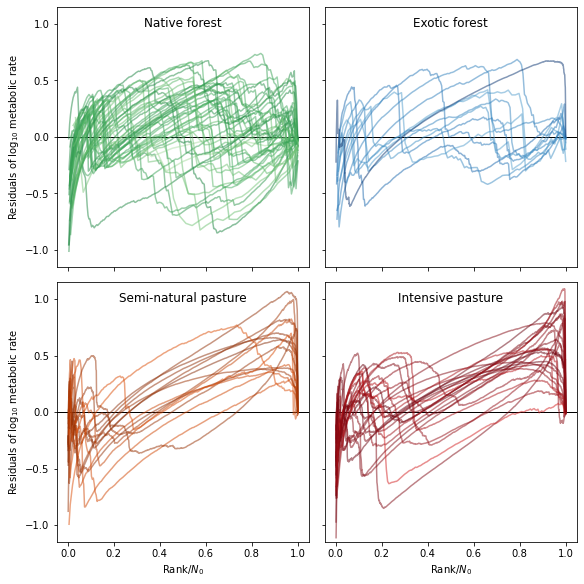

In [12]:
# Colored res
# Make color dictionary
cdic = {lu[0]:'Greens',lu[1]:'Blues',lu[2]:'Oranges',lu[3]:'Reds'}

fig,axs = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True,constrained_layout=True)
# Get max n0 for color
n0max = np.log10(max(sne['n0']))
for l, ax in zip(lu,fig.axes):
    # Set title to index
    ax.set_title(l,y=0.9)
    # Set up xline
    ax.axhline(0,c='k',zorder=0,lw=1)
    # Now loop over every site
    for s in ad[l].columns:
        # Get ranks and predicted
        ranks = np.arange(sne.loc[(l,s),'n0'])+1
        obs = mr[(l,s)][::-1]
        pred = sm.mrdi_rank(ranks,(sne.loc[(l,s),'l1'],sne.loc[(l,s),'l2']),sne.loc[(l,s),'n0'])
        # Plot observed - predicted fractional
        ax.plot(ranks/sne.loc[(l,s),'n0'],(np.log10(obs)-np.log10(pred)),
                c=plt.get_cmap(cdic[l])(np.log10(sne.loc[(l,s),'n0'])/n0max),alpha=0.5)
        # Set y limits
        ax.set_ylim(-1.15,1.15)

axs[1,0].set_xlabel(r'Rank/$N_0$')
axs[1,1].set_xlabel(r'Rank/$N_0$')
axs[0,0].set_ylabel(r'Residuals of $\log_{10}$ metabolic rate')
axs[1,0].set_ylabel(r'Residuals of $\log_{10}$ metabolic rate')
# Put colorbar legend, if we want
#fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('Greys')),ax=axs[:,1],shrink=0.7)

fig.savefig('Figures/residuals_mrdi_rank_colored.pdf', bbox_inches='tight')


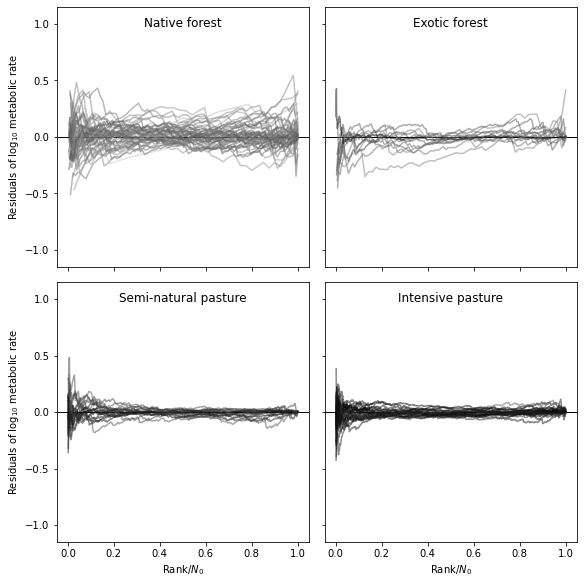

In [15]:
# Null expectations

fig,axs = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True,constrained_layout=True)
# Get max n0 for color
n0max = np.log10(max(sne['n0']))
for l, ax in zip(lu,fig.axes):
    # Set title to index
    ax.set_title(l,y=0.9)
    # Set up xline
    ax.axhline(0,c='k',zorder=0,lw=1)
    # Now loop over every site
    for s in ad[l].columns:
        # Get ranks and predicted
        ranks = np.arange(sne.loc[(l,s),'n0'])+1
        sim = sm.mrdi_rvs(sne.loc[(l,s),'n0'],(sne.loc[(l,s),'l1'],sne.loc[(l,s),'l2']))
        pred = sm.mrdi_rank(ranks,(sne.loc[(l,s),'l1'],sne.loc[(l,s),'l2']),sne.loc[(l,s),'n0'])
        # Plot observed - predicted fractional
        ax.plot(ranks/sne.loc[(l,s),'n0'],(np.log10(sim)-np.log10(pred)),
                c=plt.get_cmap('Greys')(np.log10(sne.loc[(l,s),'n0'])/n0max),alpha=0.5)
        # Set y limits
        ax.set_ylim(-1.15,1.15)

axs[1,0].set_xlabel(r'Rank/$N_0$')
axs[1,1].set_xlabel(r'Rank/$N_0$')
axs[0,0].set_ylabel(r'Residuals of $\log_{10}$ metabolic rate')
axs[1,0].set_ylabel(r'Residuals of $\log_{10}$ metabolic rate')
# Put colorbar legend, if we want
#fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('Greys')),ax=axs[:,1],shrink=0.7)

fig.savefig('Figures/residuals_mrdi_null.pdf', bbox_inches='tight')
